In [7]:
import math
import pickle
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import random
import torchio as tio
import glob
import os
import re
import pandas as pd
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
import SimpleITK as sitk
import copy
from jalert.alert import se

def generate_shuffled_list(list_path="/data1/RCC/shono_dicom2/useful_accessions.txt"):
    df=pd.read_csv('/data1/RCC/accession_DB_merged.csv',index_col=0)
    accession_id_list=[str(accession_id) for accession_id in df.index.values]
#     with open(list_path,"r") as f:
#             txt=f.read()
#     accession_id_list=txt.split(",")
    random.shuffle(accession_id_list)
    txt=",".join(accession_id_list)
    save_name=os.path.dirname(list_path)+"/useful_accessions_shuffled.txt"
    with open(save_name,"w") as f:
        f.write(txt)
def split_array(ar, n_group):
    for i_chunk in range(n_group):
        yield ar[i_chunk * len(ar) // n_group:(i_chunk + 1) * len(ar) // n_group]
        
def dic_min_len(dic):
    len_dic={}
    for key,val in dic.items():
        len_dic[key]=len(val)
    max_key = min(len_dic, key=len_dic.get)
    return max_key
#EFFECTS: テストデータセットと訓練データセットに対応するaccessionナンバーのリストを作成する。
#この時、欠損データを無視する。
#この時、不使用データ（diagnosisが不適切など）を除去する。
def Create_dataset_txt(list_path="/data1/RCC/shono_dicom2/useful_accessions.txt",save_dir="/data1/RCC/shono_dicom2/",division=4,test_chunk=0,shuffle=False):
#     with open(list_path,"r") as f:
#         txt=f.read()
#     accession_id_list=txt.split(",")
#     exclude_accession_id_list_path="/data1/RCC/shono_dicom2/exclude_accessions.txt"
#     with open(exclude_accession_id_list_path,"r") as f:
#         txt=f.read()
#     exclude_accession_id_list=txt.split(",")
#     accession_id_list=list(set(accession_id_list)-set(exclude_accession_id_list))
    df=pd.read_csv('/data1/RCC/accession_DB_merged.csv',index_col=0)
    accession_id_list=[str(accession_id) for accession_id in df.index.values]
#     accession_id_list=df.index.values
    if shuffle:
        random.shuffle(accession_id_list)
#     df=pd.read_csv('/data1/RCC/RCC_total.csv',index_col=0)
    types=["clear","papillary","chromophobe"]
    RCC_type_accession_id_list={}
    for _type in types:
        RCC_type_accession_id_list[_type]=[]
    for accession_id in accession_id_list:
#         print(accession_id)
        _type=df.at[int(accession_id),"diagnosis"]
        RCC_type_accession_id_list[_type].append(accession_id)
    RCC_type_testable_id_list={}
    RCC_type_untestable_id_list={}
    min_len_type=dic_min_len(RCC_type_accession_id_list)
#     min_len=len(RCC_type_accession_id_list[min_len_type])
    min_len=150
    min_len_list=[min_len,min_len,min_len]
#     min_len_list=[10,10,16]
    print("min_len_type:",min_len_type)
    print("min_len:",min_len)
    for type_i, _type in enumerate(types):
        RCC_type_testable_id_list[_type]=(RCC_type_accession_id_list[_type][:min_len_list[type_i]])
        RCC_type_untestable_id_list[_type]=RCC_type_accession_id_list[_type][min_len_list[type_i]:]
        print(f"type_list_{_type} len: ",len(RCC_type_testable_id_list[_type]))
    print(f"len:{len(accession_id_list)}")
    train_id_list=[]
    test_id_list=[]
    RCC_accession_group_list={}
    for i,_type in enumerate(types):
        print(f"{_type} num:{len(RCC_type_testable_id_list[_type])}")
        RCC_accession_group_list[_type]=list(split_array(RCC_type_testable_id_list[_type],division))
        chunk_id=test_chunk+i
        if chunk_id>=len(RCC_accession_group_list[_type]):
            chunk_id-=len(RCC_accession_group_list[_type])
        test_id_list+=RCC_accession_group_list[_type].pop(chunk_id)
        for accession_group_idx in range(len(RCC_accession_group_list[_type])):
            train_id_list+=RCC_accession_group_list[_type][accession_group_idx]
#         train_id_list+=RCC_type_untestable_id_list[_type]
    
#訓練データとテストデータを分割

    print(f"train_len:{len(train_id_list)}")
    print(f"test_len:{len(test_id_list)}")
    with open(save_dir+'train.data', 'wb') as f:
        pickle.dump(train_id_list,f)
    with open(save_dir+'test.data', 'wb') as f:
        pickle.dump(test_id_list,f)
    
def get_numpy_slice_id(slice_path):
    name=os.path.basename(slice_path)
    slice_id=re.sub(r"([^\-]+-[^\-]+-)?([0-9]+)(_no_pad)?.npy",r"\2",name)
    return int(slice_id)

def get_path_format_from_accession_id(accession_id):
    df=pd.read_csv('/data1/RCC/accession_DB_merged.csv',index_col=0)
    source=df.at[int(accession_id),"source"]
    path=""
    if source=="Keio":
        path=f"/data1/RCC/shono_dicom2/npy_2ds/{accession_id}/Original-1.25-*[0-9]_no_pad.npy"
    if source=="JMID":
        path=f"/data1/RCC/dicom_toda/npy_2ds/{accession_id}/[0-9].npy"
    return path
#ABSTRACT : Pytorchのデータセットを作成するクラス。
#ここでは4層を持つ腫瘍画像を4チャンネル画像として入力する。

class Create_Dataset(Dataset):
    def __init__(self,dataset_path,root_path="/data1/RCC/shono_dicom2/npy_2ds",data_transform=None,spacing_xy=None,spacing_z=1.25,ch_list=[1,2,3]):
        self.dataset_path=dataset_path
        self.root_path=root_path
        with open(dataset_path, 'rb') as f:
            accession_list=pickle.load(f)
        self.accession_path_list=[f"{root_path}/{accession}" for accession in accession_list]
#         random.shuffle(self.accession_path_list)
        self.data_transform=data_transform
        self.spacing_xy=spacing_xy
        self.spacing_xy_name=spacing_xy
        if self.spacing_xy_name==None:
            self.spacing_xy_name="Original"
        self.spacing_z=spacing_z
        self.ch_list=ch_list
    def __len__(self):
        return len(self.accession_path_list)
    def __getitem__(self,i):
        accession_path=self.accession_path_list[i]
        accession_id=os.path.basename(accession_path)
        slice_path_format=get_path_format_from_accession_id(accession_id)
        slice_list=sorted(glob.glob(slice_path_format),key=get_numpy_slice_id)
#         slice_list=sorted(glob.glob(f"{accession_path}/{self.spacing_xy_name}-{self.spacing_z}-*[0-9]_no_pad.npy"),key=get_numpy_slice_id)
        len_slice_list=len(slice_list)
        if len_slice_list*2//5!=len_slice_list*3//5:
            slice_list=slice_list[len_slice_list*2//5:len_slice_list*3//5]
        else:
            slice_list=[slice_list[len_slice_list//2]]
        slice_id=random.randint(0,len(slice_list)-1)
        data_path=slice_list[slice_id]
        data=np.load(data_path,allow_pickle=True)
        label=data[0]
        #[clear,chomophobe,papillary]の順番
        new_label_cor=[0,1,0]
        label=new_label_cor[label]
#         if self.ch_3:
        ch_list=[item+1 for item in self.ch_list]
        images=data[ch_list]
#         for img in images:
#             plt.imshow(img)
#             plt.show()
#         for i,image in enumerate(list(images)):
#             print(i,image.shape)
        image_3d=np.stack(list(images),-1)
        image=self.data_transform(image_3d)
        return label,image,accession_id

def normalize(volume):
    """Normalize the volume"""
    min = -200
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def dic_add(dic_a,dic_b):
    for k in (dic_a.keys() & dic_b.keys()):
        res_elm = [val_a + val_b for val_a,val_b in zip(dic_a[k],dic_b[k])]
        dic_a[k]=res_elm
    return dic_a
def dic_div(dic_a,division):
    for k in dic_a.keys():
        dic_a[k]=[val/division for val in dic_a[k]]

def show_accession_bbs(accession_id,foot_tag="_registered"):
#     df=pd.read_csv('/data1/RCC/RCC_total.csv',index_col=0)
    df=pd.read_csv('/data1/RCC/accession_DB_merged.csv',index_col=0)
    _type=df.at[int(accession_id),"diagnosis"]
    for k in range(1):
        img_arr_list=[]
        for layer_id in range(4):
#             path=f"/data1/RCC/shono_dicom2/dicom/{accession_id}/{layer_id}-bb-Original-1.25_registered.nii.gz"
            
            path=f"/data1/RCC/shono_dicom2/dicom/{accession_id}/{layer_id}-bb-Original-1.25{foot_tag}.nii.gz"
            if not os.path.exists(path):
                print("error")
                return 0
            sitk_img=sitk.ReadImage(path)
            img_arr_list.append(sitk.GetArrayFromImage(sitk_img))
        fig,axs=plt.subplots(1,4,figsize=(16,4))
        fig2,axs2=plt.subplots(1,4,figsize=(16,4))
        for layer_id,img_arr in enumerate(img_arr_list):
            img_arr=normalize(img_arr)
            axs[layer_id].imshow(img_arr[img_arr.shape[0]//2],cmap="bone")
            axs2[layer_id].imshow(img_arr[:,:,img_arr.shape[1]//2],cmap="bone")
        plt.show()
class ColorShift(object):
    def __init__(self,delay_range=[0,10],p=0.3):
        self.delay_range=delay_range
        self.p=p
    def __call__(self,volume):
        rd=random.uniform(0,1)
        if rd>=self.p:
            return volume
        delays=[]
        for i in range(4):
            delays.append(random.randint(self.delay_range[0],self.delay_range[1]))
#         delay2=random.randint(self.delay_range[0],self.delay_range[1])
        imgs=[volume[i] for i in range(3)]
        imgs[0]=torch.roll(imgs[0], (delays[0],delays[1]),dims=(0,1))
        imgs[2]=torch.roll(imgs[2], (delays[2],delays[3]),dims=(0,1))
        volume[0]= imgs[0]
        volume[2]= imgs[2]
#     volume[0]
        return volume

In [76]:
# df.head(100)
df=pd.read_csv('/data1/RCC/accession_DB_merged.csv',index_col=0)
df2=df.query('source=="JMID"')
df.head(15)
x="1210131116326496"
print(int(x) in df.index.values)
df.at[int(x),"diagnosis"]

min_len_type: chromophobe
min_len: 150
type_list_clear len:  150
type_list_papillary len:  39
type_list_chromophobe len:  27
len:503
clear num:150
papillary num:39
chromophobe num:27
train_len:163
test_len:53
length 53
0
img_shape torch.Size([3, 224, 224])


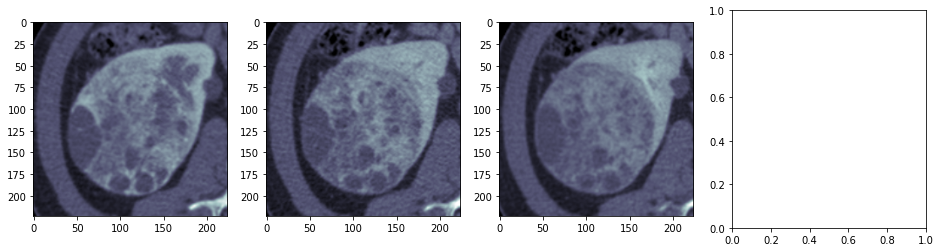

1
img_shape torch.Size([3, 224, 224])


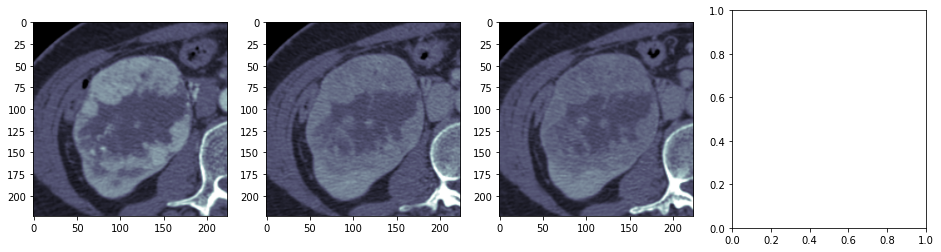

2
img_shape torch.Size([3, 224, 224])


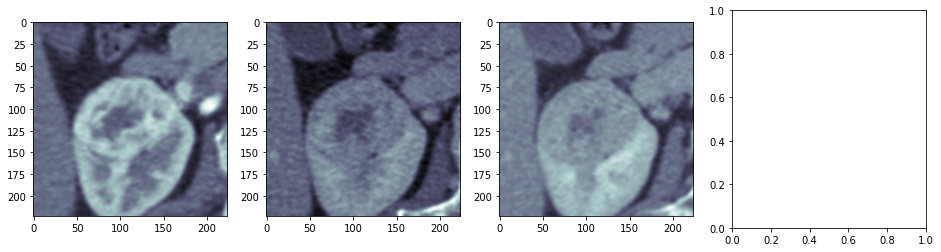

3
img_shape torch.Size([3, 224, 224])


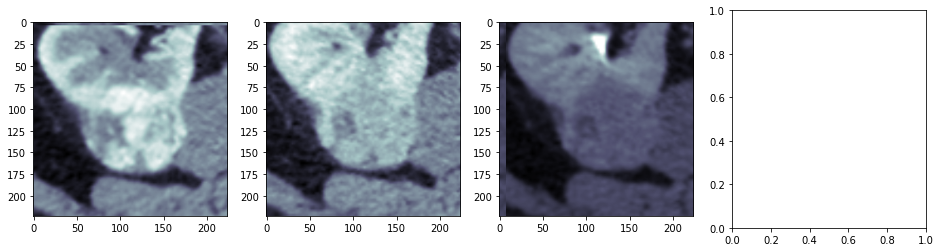

4
img_shape torch.Size([3, 224, 224])


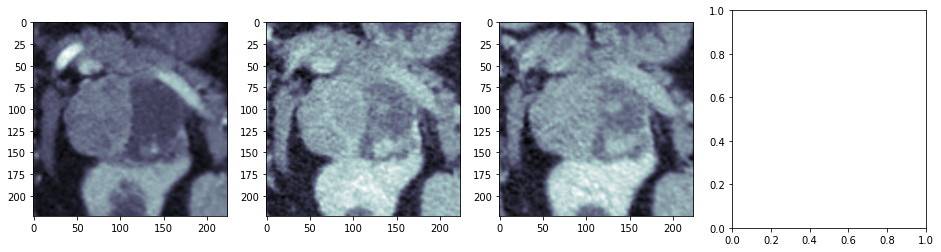

5
img_shape torch.Size([3, 224, 224])


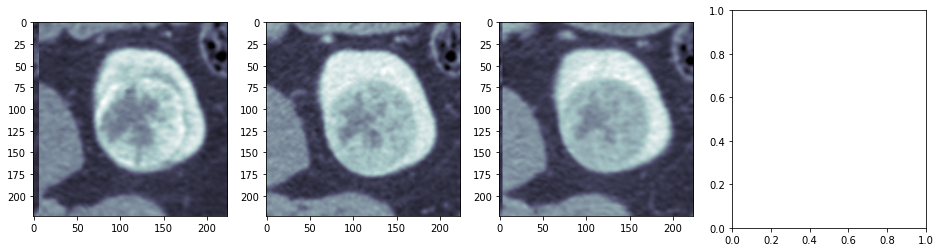

6
img_shape torch.Size([3, 224, 224])


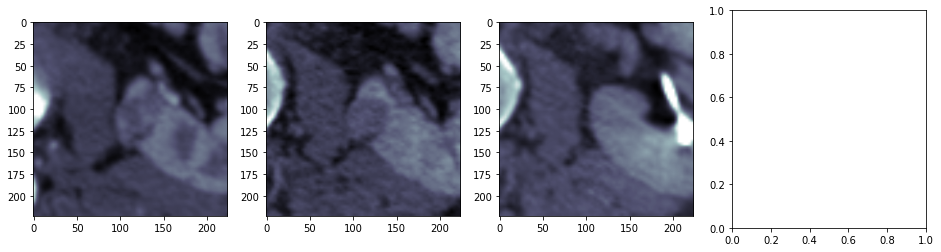

7
img_shape torch.Size([3, 224, 224])


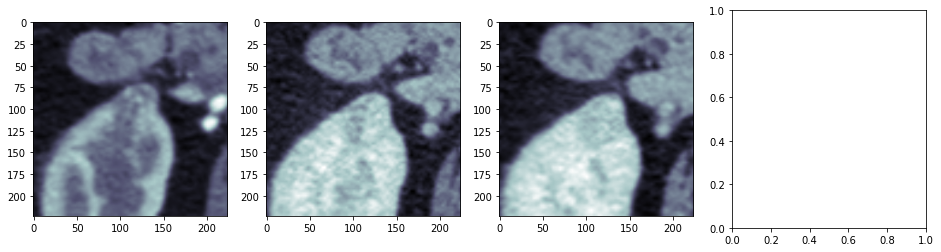

8
img_shape torch.Size([3, 224, 224])


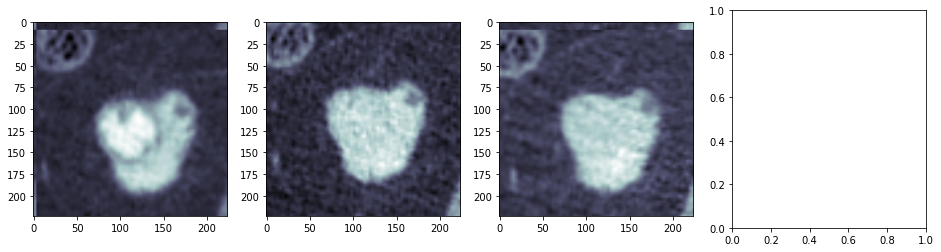

9
img_shape torch.Size([3, 224, 224])


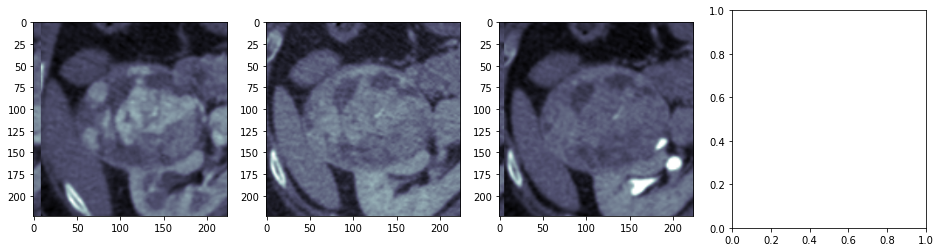

10
img_shape torch.Size([3, 224, 224])


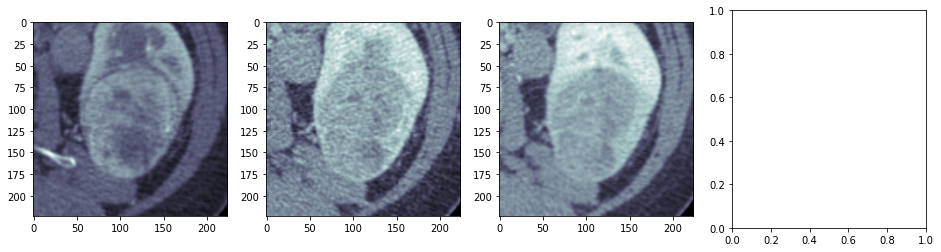

11
img_shape torch.Size([3, 224, 224])


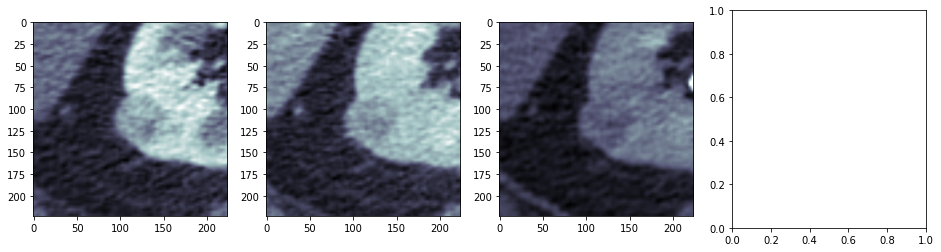

12
img_shape torch.Size([3, 224, 224])


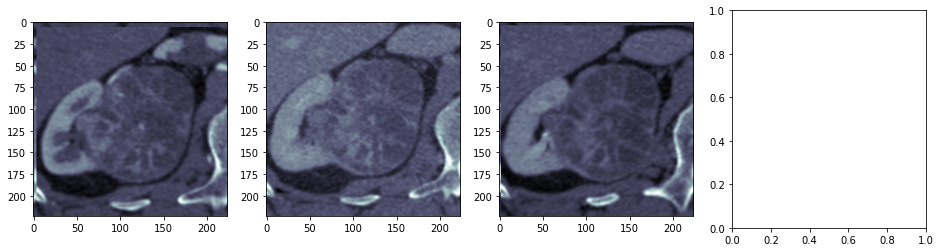

13
img_shape torch.Size([3, 224, 224])


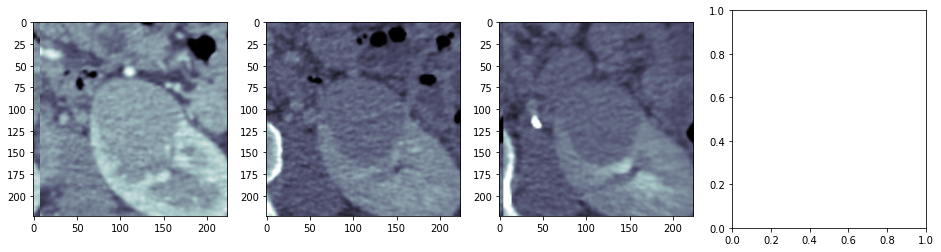

14
img_shape torch.Size([3, 224, 224])


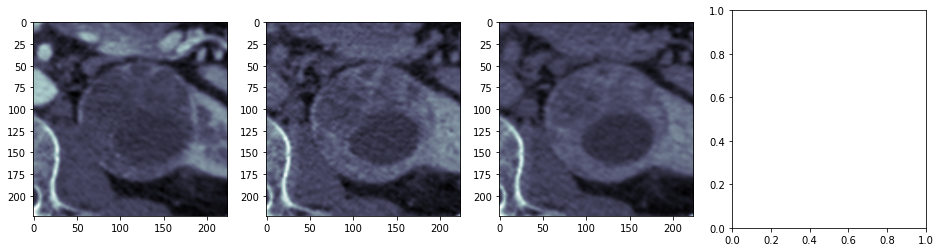

15
img_shape torch.Size([3, 224, 224])


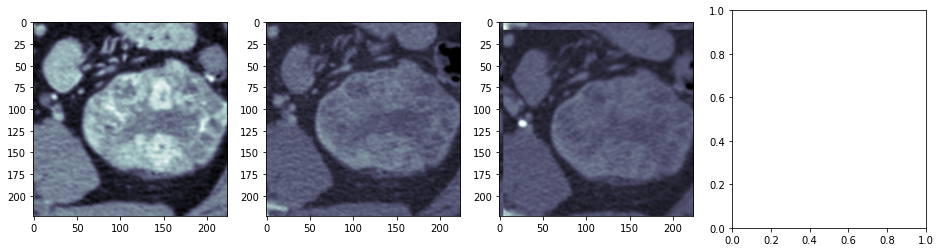

16
img_shape torch.Size([3, 224, 224])


KeyboardInterrupt: 

In [83]:
dataset_path="/data1/RCC/shono_dicom2/useful_accessions_shuffled.txt"
save_dir="/data1/RCC/shono_dicom2/"
division=4
generate_shuffled_list()
Create_dataset_txt(dataset_path,save_dir,division=division,test_chunk=2)

train_datalist_path="/data1/RCC/shono_dicom2/test.data"
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop([224,224], scale=(0.8, 1.5), ratio=(0.95,1.05), interpolation=2),
    ColorShift([0,10])
])
train_data=Create_Dataset(train_datalist_path,root_path="/data1/RCC/shono_dicom2/npy_2ds",data_transform=data_transform,spacing_xy=None,spacing_z=1.25,ch_list=[0,1,2,3])
print("length",len(train_data))
for k in range(1):
    for c in range(40):
        x=k*43+c
        print(x)
        label,img_4d,index=train_data[x]
        print("img_shape",img_4d.shape)
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        for i in range(3):
            axs[i].imshow(img_4d[i,:,:],cmap="bone")
        plt.show()

In [5]:
model_ft=models.inception_v3(pretrained=True)
model_ft.fc = nn.Linear(2048, 2)
weight=model_ft.Conv2d_1a_3x3.conv.weight.clone()
model_ft.Conv2d_1a_3x3.conv=nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
model_ft.Conv2d_1a_3x3.conv.weight[:,:3]=weight
model_ft.Conv2d_1a_3x3.conv.weight[:,3]=weight[:,1]

BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

In [12]:
#　ニューラルネットを定義。

import torch.nn as nn
import torch
from torchvision import models
from efficientnet_pytorch import EfficientNet


class TNet_2D(nn.Module):
    def __init__(self,model_use="inception",concat=False):
        super(TNet_2D, self).__init__()
        self.model_use=model_use
        if model_use=="efficient_net":
            model_ft = EfficientNet.from_pretrained('efficientnet-b5') 
            model_ft._fc = nn.Linear(2048, 2)
        elif model_use=="res_net":
            model_ft = models.resnet152(pretrained=True)
            model_ft.fc = nn.Linear(2048, 2)
            
        elif model_use=="inception":
            model_ft=models.inception_v3(pretrained=True)
            model_ft.fc = nn.Linear(2048, 2)
            model_ft.AuxLogits.fc=nn.Linear(768, 2)
        elif model_use=="inception_4ch":
            model_ft=models.inception_v3(pretrained=True)
            model_ft.fc = nn.Linear(2048, 2)
            model_ft.AuxLogits.fc=nn.Linear(768, 2)
            model_ft=models.inception_v3(pretrained=True)
            model_ft.fc = nn.Linear(2048, 2)
            with torch.no_grad():
                weight=model_ft.Conv2d_1a_3x3.conv.weight.clone()
                model_ft.Conv2d_1a_3x3.conv=nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
                model_ft.Conv2d_1a_3x3.conv.weight[:,:3]=weight
                model_ft.Conv2d_1a_3x3.conv.weight[:,3]=weight[:,1]
        elif model_use=="efficient_net_3ch":
            model_ft = EfficientNet.from_pretrained('efficientnet-b5') 
            model_ft._fc = nn.Linear(2048, 5)
        for param in model_ft.parameters():
            pass
        self.conv_phase=[]
        self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.conv_phase0=model_ft
        self.conv_phase1=copy.deepcopy(model_ft)
        self.conv_phase2=copy.deepcopy(model_ft)
        self.conv_phase3=copy.deepcopy(model_ft)
        self.mp=nn.MaxPool2d((2,2))
        self.fc1=nn.Linear(15,2)
        self.drop=nn.Dropout(p=0.08)
        self.concat=concat
    def forward(self,image0,image1,image2,image3=None):
        if (self.concat):
            print("concat")
            image0=self.conv_phase0(image0)
            image1=self.conv_phase1(image1)
            image2=self.conv_phase2(image2)
            x=torch.cat((image0,image1,image2),1)
            x=self.fc1(x)
        else:
            x=self.conv_phase0(image0)
        return x

In [9]:
#単なる確率分布に従った当てずっぽう
class Unigram:
    def __init__(self,counts):
        self.counts=counts
        self.dice=range(len(counts))
#         self.device
    def predict(self,k=1):
        return torch.tensor(random.choices(self.dice, k=k,weights = self.counts)).to(device)

In [18]:

from pprint import pprint as pp
import datetime
import time
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
import math

def as_float(volume):
    max_x=500
    min_x=-200
    volume[volume < min_x] = min_x
    volume[volume > max_x] =max_x
    volume = (volume - min_x) / (max_x - min_x)
    return volume.astype("float32")
def data_transform_train_def(img_size):
    return transforms.Compose([
        normalize,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406,0.456],[0.229, 0.224, 0.225,0.224]),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.5), ratio=(0.95,1.05), interpolation=2),
        ColorShift([0,4]),
        transforms.RandomRotation(degrees=40),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomErasing(p=0.3, scale=(0.01, 0.03), ratio=(0.5, 1.5), value=0),
    ])

def data_transform_test_def(img_size):
    return transforms.Compose([
        normalize,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406,0.456],[0.229, 0.224, 0.225,0.224]),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.5), ratio=(0.95,1.05), interpolation=2),
        ColorShift([0,0]),
    ])
# data_transform_test([229,229])
class TrainSetting:
    def __init__(self,batch_size=5,epoch_size=200,optimizer=None,
                 scheduler=None,criterion=None,model_use="inception",ch_para=False,
                train_loader=None,test_loader=None):
        self.epoch_size=epoch_size
        if optimizer==None:
            optimizer = optim.SGD(net.parameters(), lr=0.0006, momentum=0.9,weight_decay=0.00007)
        if scheduler==None:
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10, eta_min=0.0001,verbose=True)
        if criterion==None:
            criterion = nn.CrossEntropyLoss()
        self.optimizer=optimizer
        self.criterion=criterion
        self.scheduler=scheduler
        self.model_use=model_use
        self.ch_para=ch_para
        self.train_loader=train_loader
        self.test_loader=test_loader
class NetTrainer:
    def __init__(self,model,train_setting=None):
        if train_setting==None:
            train_setting=TrainSetting()
        self.ts=train_setting
        self.score_epoch_list={}
        self.labels_unique=[0,1]
        self.net=model
    def set_setting(self,train_setting):
        self.ts=train_setting
    def culc_sp(self,label_list,predicted_list,probability_list):
        result_counts_template={"TP":0,"TN":0,"FP":0,"FN":0}
        result_counts={}
        for label in self.labels_unique:
            result_counts[label]=result_counts_template.copy()
        for elm_i,(label_i,predicted_i) in enumerate(zip(label_list,predicted_list)):
            for label_ref in self.labels_unique:
                positive=0
                true_=0
                if predicted_i==label_ref:
                    positive=1
                if predicted_i==label_i:
                    true_=1
                if positive:
                    if true_:
                        result_counts[ label_ref]["TP"]+=1
                    else:
                        result_counts[ label_ref]["FP"]+=1
                else:
                    if true_:
                        result_counts[ label_ref]["TN"]+=1
                    else:
                        result_counts[ label_ref]["FN"]+=1
        if (result_counts[1]["TP"]==0):
            precision=0
            sensitivity=0
        else:
            precision=result_counts[1]["TP"]/(result_counts[1]["TP"]+result_counts[1]["FP"])
            sensitivity=result_counts[1]["TP"]/(result_counts[1]["TP"]+result_counts[1]["FN"])
        auroc_label=[]
        auprc_label=[]
        
        for label_ref in self.labels_unique:
            proba_list_ref=[proba[label_ref] for proba in probability_list]
            label_list_ref=[1 if label==label_ref else 0 for label in label_list]
            predict_list=[ 1 if proba>0.5 else 0 for proba in proba_list_ref]
            tp=0
            fp=0
            label_num_list=[label_list_ref.count(0),label_list_ref.count(1)]
            for predict,label in zip(predict_list,label_list_ref):
                if predict==1 and label==1:
                    tp+=1
                if (predict==1 and label==0):
                    fp+=1
            tpr_5=tp/label_num_list[1] if tp>0 else 0
            fpr_5=fp/label_num_list[0] if fp>0 else 0
            print("tpr05:",tpr_5," fpr05:",fpr_5)
            tp_list=[1 if predict==label else 0 for predict,label in zip(predict_list,label_list_ref)]
            fp_list=[1 if (predict==1 and label==0) else 0 for predict,label in zip(predict_list,label_list_ref)]
            fpr,tpr,thresholds = roc_curve(label_list_ref, proba_list_ref)
            precision_c, recall_c, thresholds_pr =precision_recall_curve(label_list_ref, proba_list_ref)
#             plt.plot(fpr,tpr)
#             plt.show()
#             print("proba:",proba_list_ref)
            print("label:",label_list_ref)
#             print("prediction:",predict_list)
            
            auroc=auc(fpr,tpr)
            auprc=auc(recall_c,precision_c)
            auroc_label.append(auroc)
            auprc_label.append(auprc)
        auroc=auroc_label[1]
        auprc=auprc_label[1]
        
        return precision, sensitivity,auroc,auprc,result_counts
    
    def exec_epoch(self,train=False):
        
        ts=self.ts
        if train:
            dataloader=ts.train_loader
            self.net.train()
        else:
            dataloader=ts.test_loader
            self.net.eval()
        state="train" if train else "test"
        result_data_epoch={"accession_id":[],"label":[],"predicted":[],"probability":[]}
        loss_epoch_test=0
        predicted_list=[]
        probability_list=[]
        labels_list=[]
        total=0
        correct=0
        loss_epoch=0
        for batch_i,data in enumerate(tqdm(dataloader,leave=False)):
            labels,inputs,accession_ids=data
            inputs=inputs.to(self.net.device,dtype=torch.float)
            inputs=list(torch.chunk(inputs,inputs.shape[1],dim=1))
            if ts.ch_para:
                for i in range(len(inputs)):
                    inputs[i]=torch.cat((inputs[i],inputs[i],inputs[i]), dim=1)
            else:
                inputs[0]=torch.cat((inputs[0],inputs[1],inputs[2]), dim=1)
                for i in range(len(inputs)):
                    inputs[i]=inputs[0]
            labels=labels.to(self.net.device)
            if train:
                ts.optimizer.zero_grad()

            if ts.model_use=="inception" and train:
                outputs,aux_outputs=self.net(inputs[0],inputs[1],inputs[2])
                loss1 = ts.criterion(outputs, labels)
                loss2 = ts.criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2
            else:
                outputs=self.net(inputs[0],inputs[1],inputs[2])
                loss=ts.criterion(outputs,labels)
            if train:
                loss.backward()
                ts.optimizer.step()
            _,predicted=torch.max(outputs.data, 1)
            probability=F.softmax(outputs)
            result_data_epoch["probability"]+=probability.cpu().detach().numpy().copy().tolist()
            result_data_epoch["predicted"]+=predicted.cpu().detach().numpy().copy().tolist()
            result_data_epoch["label"]+=labels.cpu().detach().numpy().copy().tolist()
            result_data_epoch["accession_id"]+=accession_ids
            total+=labels.size(0)
            correct += (predicted == labels).sum().item()
            loss_epoch+=loss
        
        ts.scheduler.step()
        acc=correct/total
        precision,sensitivity,auroc,auprc,result_counts=self.culc_sp(result_data_epoch["label"],result_data_epoch["predicted"],result_data_epoch["probability"])
        data_epoch={
            "acc":acc,
            "loss":loss_epoch,
            "precision":precision,
            "sensitivity":sensitivity,
            "auroc":auroc,
            "auprc":auprc,
        }
        return data_epoch,result_data_epoch
    def show_data_epoch(self,data_epoch,epoch):
        result="epoch:{} acc:{} loss:{} precision:{} recall:{} auroc:{} auprc:{}".format(
            epoch,data_epoch['acc'],data_epoch['loss'],data_epoch['precision'],
            data_epoch["sensitivity"],data_epoch['auroc'],data_epoch['auprc'])
        print(result)
    def train_net(self):
        self.score_epoch_list={}
        ts=self.ts
        for epoch in range(ts.epoch_size):
            data_epoch_train,result_data_epoch_train=self.exec_epoch(train=True)
            print("train")
            self.show_data_epoch(data_epoch_train,epoch)
            with torch.no_grad():
                data_epoch_test,result_data_epoch_test=self.exec_epoch(train=False)
            print("test")
            self.show_data_epoch(data_epoch_test,epoch)
            if epoch==0:
                for key in data_epoch_train.keys():
                    self.score_epoch_list[f"{key}_train"]=[]
                    self.score_epoch_list[f"{key}_test"]=[]
            for key in data_epoch_train.keys():
                self.score_epoch_list[f"{key}_train"].append(data_epoch_train[key])
                self.score_epoch_list[f"{key}_test"].append(data_epoch_test[key])
            
class CVTrainer:
    def __init__(self,ts=None,division=5):
        self.ts=ts
        self.division=division
        self.score=[]
    def show_max_score(self):
        score_total=None
        eval_by="auprc_test"
        for score_division in self.score:
            if score_total==None:
                score_total=score_division
            else:
                dic_add(score_total,score_division)
        dic_div(score_total,self.division)
        eval_score_max=max(score_total[eval_by])

        max_id=score_total[eval_by].index(eval_score_max)
        acc_max=score_total["acc_test"][max_id]
        precision_max=score_total["precision_test"][max_id]
        sensitivity_max=score_total["sensitivity_test"][max_id]
        auroc_max=score_total["auroc_test"][max_id]
        auprc_max=score_total["auprc_test"][max_id]
        print(max_id)
        print("acc",acc_max)
        print("precision",precision_max)
        print("sensitivity",sensitivity_max)
        print("auroc",auroc_max)
        print("auprc",auprc_max)
    def cross_varidation(self):
        self.score=[]
        for i in range(self.division):
            self.execute_chunk(i)
    def execute_chunk(self,test_chunk):
        dataset_path="/data1/RCC/shono_dicom2/useful_accessions_shuffled.txt"
        save_dir="/data1/RCC/shono_dicom2/"
        Create_dataset_txt(dataset_path,save_dir,division=self.division,test_chunk=test_chunk)
        train_datalist_path="/data1/RCC/shono_dicom2/train.data"
        test_datalist_path="/data1/RCC/shono_dicom2/test.data"
        model_use="inception_4ch"
        lr=0.0006
        momentum=0.9
        batch_size=5
        epoch_size=300
        
        if model_use=="inception":
            img_size=[299,299]
        elif model_use=="efficient_net":
            img_size=[456,456]
        else:
            img_size=[224,224]
        ch_list=[0,1,2,3]
        data_transform = data_transform_train_def(img_size)
        data_transform_test = data_transform_test_def(img_size)
        train_data=Create_Dataset(train_datalist_path,root_path="/data1/RCC/shono_dicom2/npy_2ds",data_transform=data_transform,spacing_xy=None,spacing_z=1.25,ch_list=ch_list)
        test_data=Create_Dataset(test_datalist_path,root_path="/data1/RCC/shono_dicom2/npy_2ds",data_transform=data_transform_test,spacing_xy=None,spacing_z=1.25,ch_list=ch_list)
        print("train_data length:",len(train_data))
        print("test_data length:",len(test_data))


        train_labels=[label for label,_,_ in train_data]
        labels_unique,counts=np.unique(train_labels,return_counts=True)
        print(f"labels_unique:{labels_unique}")
        class_weights=[sum(counts)/c for c in counts]
        # class_weights[2]=0
        example_weights=[class_weights[e] for e in train_labels]
        test_labels=[label for label,_,_ in test_data]
        test_labels_unique,test_counts=np.unique(test_labels,return_counts=True)
        print(f"labels_unique:{labels_unique}")
        test_class_weights=[sum(test_counts)/c for c in test_counts]
        # class_weights[2]=0
        test_example_weights=[test_class_weights[e] for e in test_labels]
        sampler_train = WeightedRandomSampler(example_weights,len(train_labels))
        sampler_test = WeightedRandomSampler(test_example_weights,len(test_labels))
        train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle =False,sampler=sampler_train, drop_last=True)
    #     train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle =False)
        print("train_loader_len",len(train_loader))
        test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)

        print(counts/sum(counts))
        unigram=Unigram(counts)
    #     model_use="inception"
        concat=(model_use=="efficientnet_3ch")
#         net=ResNet_2D(ch_3=True,model_use=model_use,concat=concat)
        net=TNet_2D(model_use=model_use,concat=False)
        net=net.to(net.device)
        
#         optimizer = optim.SGD(net.parameters(), lr=0.0006, momentum=0.9,weight_decay=0.00007)
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum,weight_decay=0.00005)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10, eta_min=0.00007,verbose=True)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10, eta_min=0.0001,verbose=True)
        ts=TrainSetting(batch_size=batch_size,epoch_size=epoch_size,optimizer=optimizer,
                        criterion=criterion,scheduler=scheduler,model_use=model_use,ch_para=False,
                train_loader=train_loader,test_loader=test_loader)
        
        net_trainer=NetTrainer(net,ts)
        net_trainer.train_net()
        self.score.append(net_trainer.score_epoch_list)
    
            
            




In [19]:
import time

start=time.time()
print(start)
trainer=CVTrainer()
trainer.cross_varidation()
trainer.show_max_score()
end=time.time()
elapsed_time=end-start
print(f"time : {elapsed_time/60} min")
se()

1626158766.4499826
min_len_type: chromophobe
min_len: 150
type_list_clear len:  150
type_list_papillary len:  39
type_list_chromophobe len:  27
len:503
clear num:150
papillary num:39
chromophobe num:27
train_len:172
test_len:44
train_data length: 172
test_data length: 44
labels_unique:[0 1]
labels_unique:[0 1]
train_loader_len 34
[0.87790698 0.12209302]
Adjusting learning rate of group 0 to 6.0000e-04.


  0%|          | 0/34 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [32, 4, 3, 3], expected input[5, 3, 224, 224] to have 4 channels, but got 3 channels instead

In [87]:
trainer.show_max_score()
print(f"time : {elapsed_time/60} min")

154
acc 0.9201510117789187
precision 0.8800000000000001
sensitivity 0.43466666666666665
auroc 0.9435267899478426
auprc 0.7742429314025805
time : 103.11598022381465 min


min_len_type: chromophobe
min_len: 38
len:215
clear num:38
papillary num:22
chromophobe num:16
train_len:62
test_len:14
train_data length: 62
test_data length: 14
labels_unique:[0 1]
labels_unique:[0 1]
train_loader_len 13
[0.70967742 0.29032258]


NameError: name 'ResNet_2D' is not defined

min_len_type: chromophobe
min_len: 38
len:215
clear num:38
papillary num:22
chromophobe num:16
train_len:62
test_len:14


UnboundLocalError: local variable 'data_transform_test' referenced before assignment

In [ ]:
# print(0)
# print(result_data[0][0])
# print(1)
# print(result_data[1][0])
def get_result_data_epoch(result_data,epoch_i):
    result_data_epoch={'accession_id':[],"label":[],"predicted":[]}
    for result_data_div in result_data:
        for key in result_data_epoch.keys():
            result_data_epoch[key]+=result_data_div[epoch_i][key]
    return result_data_epoch


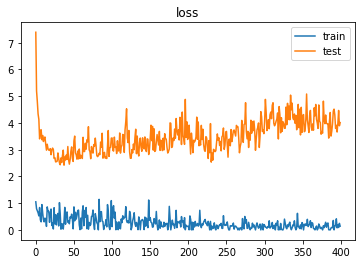

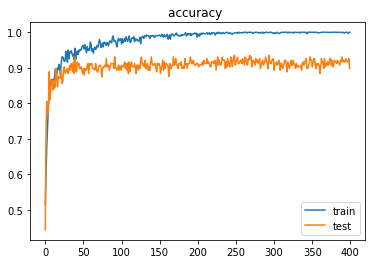

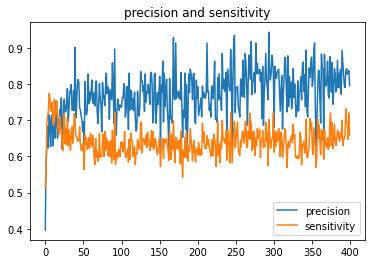

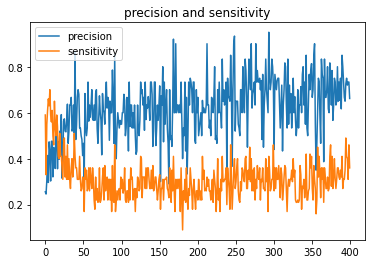

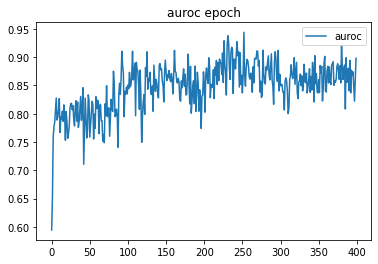

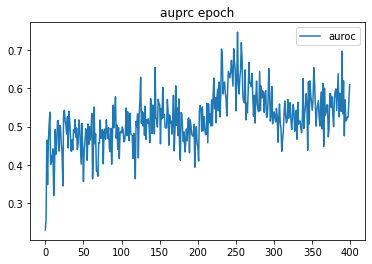

In [91]:
plt.plot(score_total["loss_train"],label="train")
plt.plot(score_total["loss_test"],label="test")
plt.title(f"loss")
plt.legend()
plt.show()
plt.plot(score_total["acc_train"],label="train")
plt.plot(score_total["acc_test"],label="test")
# plt.plot(h_u_acc,label="unigram")
plt.title(f"accuracy ")
plt.legend()
plt.show()
plt.plot(score_total["precision_test"],label="precision")
plt.plot(score_total["sensitivity_test"],label="sensitivity")
plt.title(f"precision and sensitivity")
plt.legend()
plt.show()
plt.plot(score_total["precision_solo_test"],label="precision")
plt.plot(score_total["sensitivity_solo_test"],label="sensitivity")
plt.title(f"precision and sensitivity")
plt.legend()
plt.show()
plt.plot(score_total["auroc"],label="auroc")
plt.title(f"auroc epoch")
plt.legend()
plt.show()
plt.plot(score_total["auprc"],label="auroc")
plt.title(f"auprc epoch")
plt.legend()
plt.show()

In [78]:
eval_score="auprc"
eval_score_max=max(score_total[eval_score])

max_id=score_total[eval_score].index(eval_score_max)
acc_max=score_total["acc_test"][max_id]
precision_max=score_total["precision_solo_test"][max_id]
sensitivity_max=score_total["sensitivity_solo_test"][max_id]
auroc_max=score_total["auroc"][max_id]
auprc_max=score_total["auprc"][max_id]

print(max_id)
print("acc",acc_max)
print("precision",precision_max)
print("sensitivity",sensitivity_max)
print("auroc",auroc_max)
print("auprc",auprc_max)

0
acc 0
precision 0
sensitivity 0
auroc 0
auprc 0


In [93]:
# print(get_result_data_epoch(result_data,max_id))
res=get_result_data_epoch(result_data,max_id)
accessions={"TP":[],"FP":[],"TN":[],"FN":[]}
for accession_id,label,predicted in zip(res["accession_id"],res["label"],res["predicted"]):
    _true=0
    _positive=0
    if label==predicted:
        _true=1
    if  predicted==1:
        _positive=1
    _state=""
    if _true and _positive:
        _state="TP"
    elif _true and not _positive:
        _state="TN"
    elif not _true and _positive:
        _state="FP"
    else:
        _state="FN"
    accessions[_state].append(accession_id)
# for key in accessions.keys():
#     print(key)
#     print(len(accessions[key]))
#     max_len=min(len(accessions[key]),16)
#     for accession_id in accessions[key][0:max_len]:
#         print(accession_id," / ",key)
#         show_accession_bbs(accession_id)
        
precision=len(accessions["TP"])/(len(accessions["TP"])+len(accessions["FP"]))
sensitivity=len(accessions["TP"])/(len(accessions["TP"])+len(accessions["FN"]))
print(len(accessions["TP"]))
print(len(accessions["TP"])+len(accessions["FN"]))
print(precision,sensitivity)
# key="FN"
# print(key)
# for accession_id in accessions[key]:
#     print(accession_id)
#     show_accession_bbs(accession_id)
# key="FP"
# print(key)
# for accession_id in accessions[key]:
#     print(accession_id)
#     show_accession_bbs(accession_id)

9
22
0.8181818181818182 0.4090909090909091


In [ ]:
plt.plot(score_total["acc_test"])

In [ ]:
print("hello")

In [183]:
x=[[2,3,4],[2,2,2]]
print(x[1][2])

2


Counter({'clear': 188, 'papillary': 22, 'chromophobe': 16})


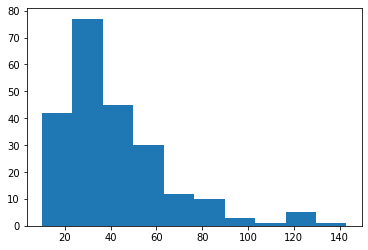

In [127]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

list_path="/data1/RCC/shono_dicom2/useful_accessions.txt"
with open(list_path,"r") as f:
    txt=f.read()
accession_id_list=txt.split(",")
# accession_id_list=[os.path.basename(path) for path in sorted(glob.glob("/data1/RCC/shono_dicom/dicom/*[0-9]"))]
# print(accession_id_list)
d_uses=["clear","chromophobe","papillary"]
df=pd.read_csv('/data1/RCC/RCC_total.csv',index_col=0)
# phase_path_list=sorted(glob.glob(accession_url+f"/[0-9]-bb{spacing[0]}.nii.gz"))
d_uses=["clear","chromophobe","papillary"]
label_list=[]
label_int_list=[]
R_list=[]

Z_list=[]
for accession_id in accession_id_list:
#     print(accession_id)
    _type=df.at[int(accession_id),"diagnosis"]
    R=df.at[int(accession_id),"R(mm)"]
    
    R_list.append(R)
    label_list.append(_type)
#     label=d_uses.index(_type)
#     label_int_list.append(label)
#     data_path=f"/data1/RCC/shono_dicom/npy/{accession_id}/2.5.npy"
#     data=np.load(data_path,allow_pickle=True)
    
#     Z_list.append(data[1].shape[0])
# plt.hist(Z_list)
# plt.show()
l_count=Counter(label_list)
print(l_count)
# R_mm_list=[R*2.5 for R in R_list]
plt.hist(R_list)
plt.show()


# print(l_count)

In [33]:
from torchvision import datasets, models, transforms
model_ft = models.resnet18(pretrained=True)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  